In [52]:
import pandas as pd
import plotly.express as px
from pages.country_profile import data
import pandas as pd



In [70]:
df = data[data.Aggregation.isin(['Index', 'Dimension'])].pivot(index=['ISO', 'Year', 'Continent', 'UNregion', 'IncomeLevel'], columns='Variable', values='Value').dropna()

In [71]:
from sklearn.decomposition import PCA

In [72]:
pca = PCA(n_components=2)

In [73]:
pca.fit(df.drop(columns=['Index']).values)

PCA(n_components=2)

In [74]:
res= pd.DataFrame(pca.transform(df.drop(columns=['Index']).values), columns=['dim_1', 'dim_2'])
res[['ISO', 'Year', 'Continent', 'UNregion', 'IncomeLevel', 'Index']] =df.reset_index()[['ISO', 'Year', 'Continent', 'UNregion', 'IncomeLevel', 'Index']]

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

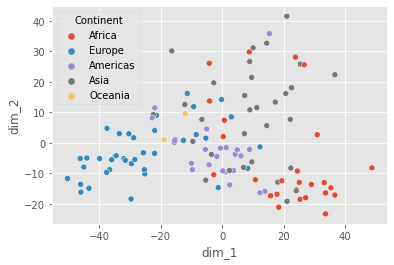

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(10, 10))
sns.scatterplot(data=res.query("Year == 2012"), x='dim_1', y='dim_2', hue='Continent')

In [47]:
df

Variable                                                  ESRU   GEO  Index  \
ISO Year   Continent UNregion       IncomeLevel                               
AFG 2013.0 Asia      Southern Asia  Low income           48.62  6.01  24.19   
    2014.0 Asia      Southern Asia  Low income           49.31  5.95  24.36   
    2015.0 Asia      Southern Asia  Low income           65.44  5.81  25.87   
    2016.0 Asia      Southern Asia  Low income           67.01  6.12  27.62   
    2017.0 Asia      Southern Asia  Low income           67.11  5.98  27.54   
...                                                        ...   ...    ...   
ZWE 2015.0 Africa    Eastern Africa Lower middle income  57.42  3.98  29.72   
    2016.0 Africa    Eastern Africa Lower middle income  57.37  3.88  29.50   
    2017.0 Africa    Eastern Africa Lower middle income  57.56  4.06  29.75   
    2018.0 Africa    Eastern Africa Lower middle income  57.57  4.19  29.94   
    2019.0 Africa    Eastern Africa Lower middle income  57.58  4.19  29.80   

Variable                                                   NCP     SI  
ISO Year   Continent UNregion       IncomeLevel                        
AFG 2013.0 Asia      Southern Asia  Low income           36.96  31.71  
    2014.0 Asia      Southern Asia  Low income           36.80  32.63  
    2015.0 Asia      Southern Asia  Low income           36.72  32.11  
    2016.0 Asia      Southern Asia  Low income           37.06  38.30  
    2017.0 Asia      Southern Asia  Low income           37.22  38.50  
...                                                        ...    ...  
ZWE 2015.0 Africa    Eastern Africa Lower middle income  78.17  43.71  
    2016.0 Africa    Eastern Africa Lower middle income  78.36  43.42  
    2017.0 Africa    Eastern Africa Lower middle income  78.24  42.79  
    2018.0 Africa    Eastern Africa Lower middle income  78.33  42.53  
    2019.0 Africa    Eastern Africa Lower middle income  78.42  41.71  

[2209 rows x 5 columns]

In [50]:
compo_df = pd.DataFrame(pca.components_.T, columns=['PC_1', 'PC_2'])
compo_df['dimension'] = df.drop(columns=['Index']).columns

<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

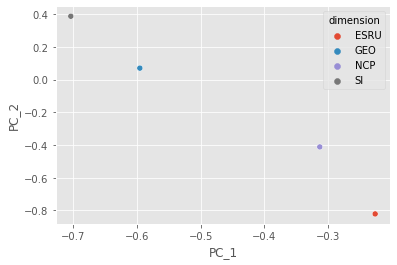

In [59]:
sns.scatterplot(data=compo_df, x='PC_1', y='PC_2', hue='dimension')

In [49]:
indicator_property = pd.read_csv('data/indicators/indicator_properties.csv', index_col=0)
indicator_property['Category'] = indicator_property['Indicator'].apply(lambda x: x[0:2])
data = pd.merge(data, indicator_property[['Category', 'Dimension']].drop_duplicates(), left_on='Variable', right_on='Category', how='left')


In [ ]:

def circular_plot(ISO):
    df = data[(data.ISO.isin([ISO])) & (data.Aggregation == 'Category') & (data.Year == 2019)].fillna(0)   
    for dim in df.Dimension.unique():
        df = df.append({'Variable': f'{dim}', 'Value':0, 'Dimension': dim}, ignore_index=True)

    index = data[(data.ISO.isin([ISO])) & (data.Variable == 'Index') & (data.Year == 2019)].Value.unique()[0]
    fig = px.bar_polar(df,
                       theta='Variable',
                       r='Value',
                       range_r=[-30, 100],
                       color='Dimension',
                       hover_data={'Variable_name':True, 'Variable': False},
                       color_discrete_map={
                          "Natural Capital Protection": "#89afc5",
                          "Social Inclusion": "#c7829d",
                          "Efficiant and Sustainable Resource Use": "#cc8608",
                          "Green Economic Opportunities": "#93c186"
                      },
                       labels={'Year': 'Year', 'Value': 'Score', 'Category': 'Dimension', 'Variable_name': 'Category'}
                      )
    
    fig.update_traces(offset=-4/12)
    fig.update_polars(radialaxis=dict(gridcolor='white',
                                      dtick=20,
                                      gridwidth=3,
                                      ticks='',
                                      angle=0,
                                      tickangle=0,
                                      tickvals = [20, 40, 60, 80],
                                      showline=True,
                                      linewidth=0,
                                      side='clockwise',
                                      ),
                      
                      
                      
                  angularaxis=dict(showgrid=False, rotation=90 - 1 * 360 / 20, ticks='',
                                   linewidth=1, linecolor='green',  #showticklabels=False,
                                   tickvals=[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18],
                                  ))
    
    fig.update_layout(
    title_text="Distances to targets",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text=f'{index}', x=0.5, y=0.5, font_size=20, showarrow=False, font_color='green'),
                 ])
    return fig

fig = circular_plot('DNK')
fig

In [5]:
import plotly.graph_objects as go
from app import data
data = add_reference_to_data(data)
indicator_property = pd.read_csv('data/indicators/indicator_properties.csv', index_col=0)
indicator_property['Category'] = indicator_property['Indicator'].apply(lambda x: x[0:2])
data = pd.merge(data, indicator_property[['Category', 'Dimension']].drop_duplicates(), left_on='Variable', right_on='Category')


def ISO_category_heatmap(ISO):
    REF_1 = 'AVG_' + "_".join(data[data.ISO == ISO][["IncomeLevel"]].drop_duplicates().values[0].tolist())
    REF_2 = 'AVG_' + "_".join(data[data.ISO == ISO][["Continent"]].drop_duplicates().values[0].tolist())

    df = data[(data.ISO.isin([ISO, REF_1, REF_2])) & (data.Aggregation == 'Category') & (data.Year == 2019)].fillna(0)
    df = df.round(2)
    continent = df.Continent.values[0]
    
    cats = ['EE', 'EW', 'SL', 'ME',
            'EQ', 'GE', 'BE', 'CV',
            'AB', 'GB', 'SE', 'SP',
            'GV', 'GT', 'GJ', 'GN']
    
    df = df.pivot(index=['ISO'], columns=['Variable'], values='Value')#[cats]
    
    fig = go.Figure(data=go.Heatmap(
                       z=df.values,
                       x=df.columns,
                       y=df.index,
                       ygap=3,
                       hoverongaps = False,
                       colorscale= px.colors.diverging.RdYlGn,
                       colorbar=dict(title='Score', tickvals=[1, 20, 40, 60, 80, 100],)),
                   )

    fig.update_xaxes(side='top')
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
    
    return fig

ISO_category_heatmap('FRA')

NameError: name 'px' is not defined

In [6]:
from app import data
import numpy as np
import pandas as pd

def add_reference_to_data(data):
    data['Continental_Rank'] = data.groupby(["Year", "Continent", "Variable"])["Value"].rank(method='dense', ascending=False)
    
    data['Income_Rank'] = data.groupby(["Year", "IncomeLevel", "Variable"])["Value"].rank(method='dense', ascending=False)


    Income_region_group = data.groupby(['Variable', 'Year', 'IncomeLevel', 'Region', 'Aggregation']).mean().reset_index()
    Income_region_group['ISO'] = 'AVG' + '_' + Income_region_group["IncomeLevel"] + '_' + Income_region_group["Region"]

    Income_group = data.groupby(['Variable', 'Year', 'IncomeLevel', 'Aggregation']).mean().reset_index()
    Income_group['ISO'] = 'AVG' + '_' + Income_group["IncomeLevel"]
    Income_group['Continental_Rank'] = np.nan
    Income_group['Income_Rank'] = np.nan


    Region_group = data.groupby(['Variable', 'Year', 'Continent', 'Aggregation']).mean().reset_index()
    Region_group['ISO'] = 'AVG' + '_' + Region_group["Continent"]
    Region_group['Continental_Rank'] = np.nan
    Region_group['Income_Rank'] = np.nan

    data = pd.concat([data, Income_region_group, Region_group, Income_group])
    
    return data
def make_continent_heatmap_df(Continent):
    '''Sacré bricolage'''
    
    df = data[(data.Continent == Continent) & (data.Aggregation.isin(['Dimension', 'Index'])) & (data.Year.isin([2005, 2019]))].fillna(0)
    df = df.round(2).astype({'Year':int})
    
    dimension_df = (df.query("Year == 2019").replace(2019, 'Dimensions 2019')
           .pivot(index=['Country', 'UNregion'], columns=['Variable', 'Year'], values='Value')
           .loc[:, (['ESRU', 'NCP', 'GEO', 'SI'], slice(None))]
           .swaplevel(0, 1, axis=1)
       )
    
    index_df = (df.pivot(index=['Country', 'UNregion'], columns=['Variable', 'Year'], values='Value')
          .loc[:, (['Index'], slice(None))]
          .droplevel(level='Variable', axis=1)
       )
    
    rank_df = (df.query("Variable == 'Index'")[['Country', 'UNregion', 'Continental_Rank', 'Year']].astype({'Continental_Rank': pd.Int64Dtype()})
                 .pivot(index=['Country', 'UNregion'], columns='Year', values='Continental_Rank'))
    
    index_rank_df = pd.concat([index_df, rank_df], axis=1, keys=['Index', "Rank"]).swaplevel(0, 1, axis=1)[[2005, 2019]]

    
    df = pd.concat([dimension_df, index_rank_df], axis=1).sort_values(by=[(2019, 'Rank')]).dropna(subset=[(2019, 'Rank')])
    
    return df


df = make_continent_heatmap_df('Africa').reset_index()#.droplevel(level='Variable', axis=1)

In [7]:
df

Year           Country         UNregion Dimensions 2019                       \
Variable                                           ESRU    NCP    GEO     SI   
0             Tanzania   Eastern Africa           71.77  66.89  47.50  41.77   
1              Morocco  Northern Africa           50.34  73.63  26.34  72.16   
2              Tunisia  Northern Africa           28.27  61.76  46.09  75.42   
3         South Africa  Southern Africa           40.14  59.22  35.41  67.24   
4           Cabo Verde   Western Africa           67.97  68.39  15.40  69.17   
5              Senegal   Western Africa           70.00  65.62  18.53  43.76   
6            Mauritius   Eastern Africa           59.21  53.20  12.96  84.43   
7               Uganda   Eastern Africa           65.41  69.92  23.65  31.63   
8                Egypt  Northern Africa           24.87  54.85  39.68  61.17   
9             Ethiopia   Eastern Africa           57.88  67.24  26.01  29.98   
10               Ghana   Western Africa           69.80  68.23  11.99  51.76   
11            Botswana  Southern Africa           66.41  58.75  12.24  53.92   
12            Cameroon    Middle Africa           67.58  59.76  12.86  43.61   
13               Kenya   Eastern Africa           62.67  62.48  10.28  53.68   
14          Madagascar   Eastern Africa           60.35  56.36  15.49  31.39   
15              Angola    Middle Africa           76.39  56.04   7.17  40.59   
16             Lesotho  Southern Africa           56.76  45.40   8.23  50.88   
17              Zambia   Eastern Africa           65.23  59.62   8.14  32.63   
18              Malawi   Eastern Africa           62.08  76.44   7.47  27.22   
19             Burundi   Eastern Africa           58.59  68.51   6.65  34.23   
20            Zimbabwe   Eastern Africa           57.58  78.42   4.19  41.71   
21             Algeria  Northern Africa           28.43  45.45   7.19  66.27   
22             Nigeria   Western Africa           67.97  57.23   4.17  36.18   
23               Niger   Western Africa           59.67  48.93   4.83  25.47   

Year       2005         2019       
Variable  Index  Rank  Index Rank  
0         37.62     9  55.55    1  
1         45.02     4  51.52    2  
2         44.21     5  49.63    3  
3         49.95     2  48.78    4  
4         58.20     1  47.17    5  
5         41.95     6  43.93    6  
6         48.18     3  43.09    7  
7         39.00     8  43.01    8  
8         35.42    10  42.65    9  
9         29.96    16  41.74   10  
10        41.74     7  41.46   11  
11        33.48    12  40.06   12  
12        32.40    14  38.79   13  
13        32.52    13  38.34   14  
14        34.23    11  35.86   15  
15          NaN  <NA>  33.41   16  
16        25.58    21  32.23   17  
17        24.49    22  31.88   18  
18        26.91    20  31.34   19  
19        20.96    23  30.92   20  
20        29.72    17  29.80   21  
21        32.36    15  28.01   22  
22        28.06    19  27.68   23  
23        20.69    24  24.48   24

In [ ]:
df = make_continent_heatmap_df('Africa').reset_index()
colnames = (df.columns.to_frame()['Year'].astype(str) + '_' + df.columns.to_frame()['Variable']).values
df.columns= colnames

In [ ]:
df

In [ ]:
df['2005_Rank']#.astype(str)

In [ ]:

data = add_reference_to_data(data)


def make_continent_heatmap_df(Continent):
    '''Sacré bricolage'''
    
    df = data[(data.Continent == Continent) & (data.Aggregation.isin(['Dimension', 'Index'])) & (data.Year.isin([2005, 2019]))].fillna(0)
    df = df.round(2).astype({'Year':int})
    
    dimension_df = (df.query("Year == 2019").replace(2019, 'Dimensions 2019')
           .pivot(index=['Country', 'UNregion'], columns=['Variable', 'Year'], values='Value')
           .loc[:, (['ESRU', 'NCP', 'GEO', 'SI'], slice(None))]
           .swaplevel(0, 1, axis=1)
       )
    
    index_df = (df.pivot(index=['Country', 'UNregion'], columns=['Variable', 'Year'], values='Value')
          .loc[:, (['Index'], slice(None))]
          .droplevel(level='Variable', axis=1)
       )
    
    rank_df = (df.query("Variable == 'Index'")[['Country', 'UNregion', 'Continental_Rank', 'Year']].astype({'Continental_Rank': float})
                 .pivot(index=['Country', 'UNregion'], columns='Year', values='Continental_Rank'))
    
    index_rank_df = pd.concat([index_df, rank_df], axis=1, keys=['Index', "Rank"]).swaplevel(0, 1, axis=1)[[2005, 2019]]

    
    df = pd.concat([dimension_df, index_rank_df], axis=1).sort_values(by=[(2019, 'Rank')]).dropna(subset=[(2019, 'Rank')])
    
    return df


df = make_continent_heatmap_df('Africa').reset_index()
print(df)
print()
colnames = (df.columns.to_frame()['Year'].astype(str) + '_' + df.columns.to_frame()['Variable']).values
df.columns= colnames


In [ ]:
df